#Automating Binwidth for pyplot.hist

When using pyplot.hist, the main problem I face is the fact that the number of bins is not dynamic. So whether I have a 50 samples or 5 million samples, by default I have 10 bins. I have to experiment until I get something I like, I don't even get a half decent choice, like in R, nor are different methods avaiable for automatically choosing the binwidths.

For example

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
%load_ext rpy2.ipython

In [2]:
def gen3peaks(numPoints):
    numPoints/=3
    x1 = np.random.randn(numPoints) * 15 + 100
    x2 = np.random.randn(numPoints) * 10 + 60
    x3 = np.random.randn(numPoints) * 5+ 140
    return np.hstack((x1,x2, x3))

xbig = gen3peaks(30000)
xsmall = gen3peaks(150)

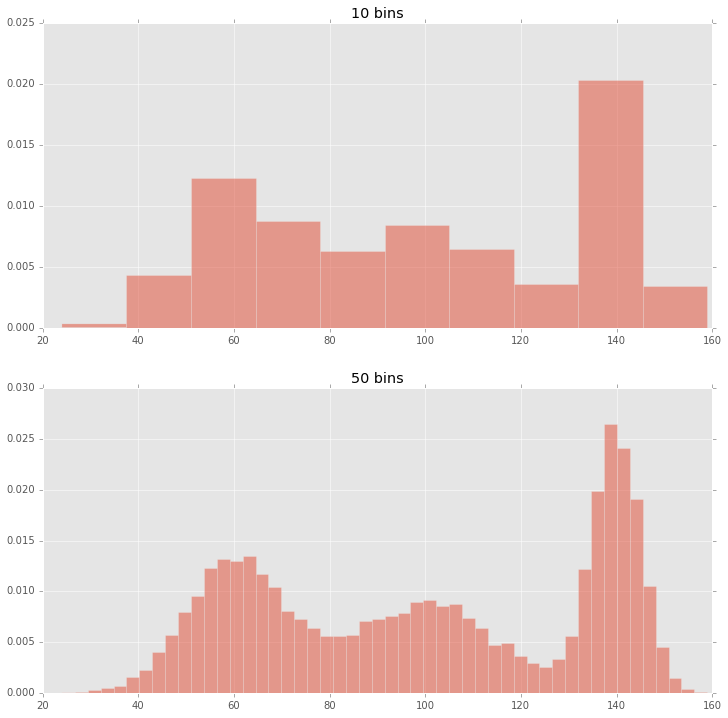

In [3]:
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.hist(xbig, normed=True, alpha = 0.5)
plt.title("10 bins")
plt.subplot(212)
plt.hist(xbig, normed=True, alpha = 0.5, bins = 50) # manual increase
plt.title("50 bins")

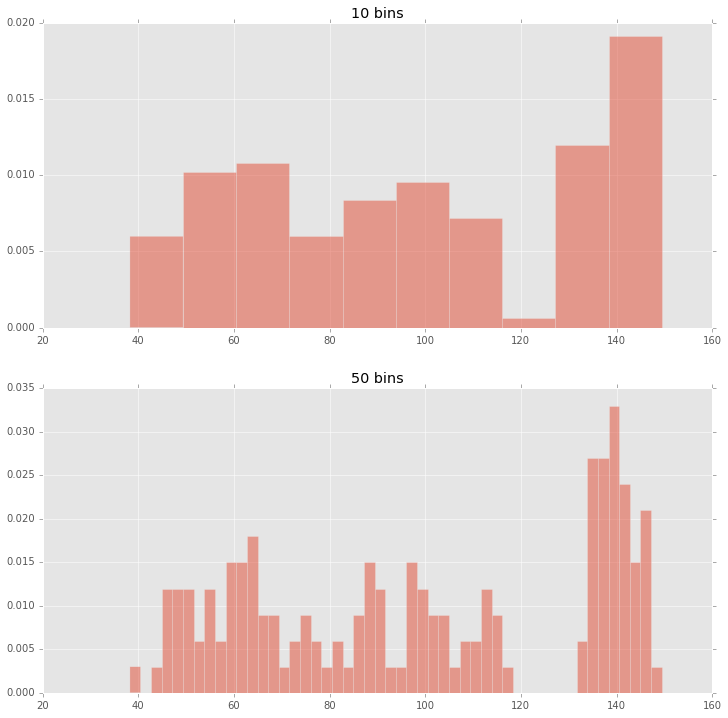

In [11]:
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.hist(xsmall, normed=True, alpha = 0.5)
plt.title("10 bins")
plt.subplot(212)
plt.hist(xsmall, normed=True, alpha = 0.5, bins = 50) # manual increase
plt.title("50 bins")

In [4]:
%R -i xbig,xsmall

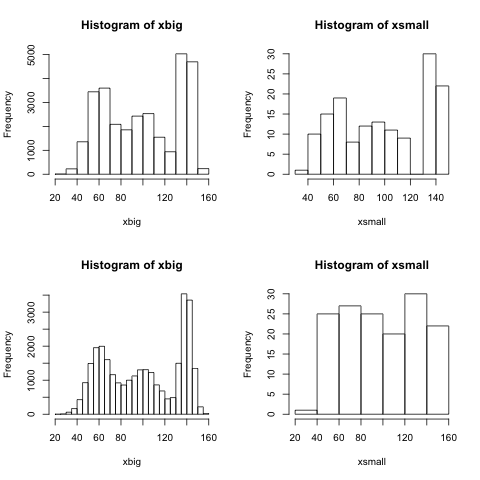

In [12]:
%%R
# par(fin = c(12,12))  # doesn't work well in ipython
par(mfrow=c(2,2))
hist(xbig);
hist(xsmall);
#second row is scott
hist(xbig, 'scott');
hist(xsmall, 'scott');

It is obvious that R is clearly adapting to the amount and the type of data being passed in (even giving options for the automatic bin selection). It should be noted that R has a `pretty` method that interferes a little bit, making the sections start on whole numbers, with preference given to multiples of 2 and 5 and some freedom to increase or decrease the number of bins. Either way, the hist method that R provides gives us better functionality out of the box.

#Solution

Provide some kind of similar functionality for hist. 

Asymptotic theory states that the optimal number of bins is 

In [ ]:
def min6decorator(func):
    """"
    Decorate the estimators in case we need to provide a lower bound
    """
    def inner(*args, **kwargs):
        return max(func(*args, **kwargs), 6)
    return inner

def sturges(x):
    """
    Using Sturges estimator
    Very simplistic based on logarithms, however poorer performance for large datasets and non-normal data
    """
    return np.ceil(np.log2(x.size)) + 1

def rice(x):
    """
    A similar version of sturges with another simple estimator. Better performance for larger datasets
    """
    return np.ceil(2 * len(x) ** (1.0/3))


def SturgesRice(x):
    """
    An average or the Rice and Sturges - works surprisingly well in practice
    """
    return np.ceil((rice(x) + sturges(x))/2)

def scott(x):
    """
    The binwidth is scaled using
    """
    h = 3.5 * x.std() * x.size **(-1.0/3)
    if h>0:
        return np.ceil(x.ptp()/h)
    return 1

def mad(data, axis=None):
    """
    Mean Absolute Deviation - simple function
    """
    return np.median(np.absolute(data - np.median(data, axis)), axis)

def FD(x):
    """
    Freeman Diaconis rule using IQR for binwidth
    Considered a variation of the Scott rule with more 
    """
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    
    if iqr ==0: #unlikely
        iqr = mad(x) # replace with something useful
    
    if iqr > 0:
        return np.ceil(x.ptp()/(2 * iqr * x.size**(-1.0/3)))

    return 1 #all else fails